#  Hybrid - Part 2: Semi-supervised Learning Modelling

**Environment Setup**

In [1]:
#Loading key libraries for later analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
pd.set_option('max_colwidth', 1000)
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
!pip install xgboost
!pip install spacy
import sklearn   
import scipy.io as scio
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.semi_supervised import LabelPropagation
from scipy import stats
from sklearn.model_selection import cross_val_score, cross_validate,StratifiedKFold,GridSearchCV
from sklearn.svm import SVC
import functions
from functions import TriTraining,PseudoLabeler


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.



In [3]:
#Read in bank transactions
df = pd.read_csv(r'df_postfeat_no_direct_FINAL.csv',low_memory=False,encoding='latin1')

In [5]:
#External resources
stopwords = pd.read_csv(r'stopwords.csv',low_memory=False,encoding='latin1')
abb = pd.read_csv(r'normalisation.csv',low_memory=False,encoding='latin1')

In [57]:
def gridsearch(model,param):
    kfold = StratifiedKFold(n_splits=5,random_state=200,shuffle=True)
    np.random.seed(0)
    clf=GridSearchCV(model,param, cv=kfold, n_jobs=-1)
    clf.fit(X_train, y_train)
    return clf.best_params_

In [6]:
import os
os.getcwd()

'/project'

## 1. Text Preprocessing

In [6]:
df_ = df.copy()

### 1.1 Stopword and special character Removals

In [6]:
#remove stopwords and special characters
functions.removals(df,stopwords,'description')
#remove multi-spaces 
df.description = df.description.replace('\s+', ' ', regex=True)
#remove transactions without descriptions
df = df[df['description'] != '']

### 1.2 Text Normalisation

In [8]:
#Normalise abbrivations to standard form
functions.abbrivations(df,'description')

### 1.3 Tokenisation and Lemmatisation

In [9]:
#Tokenisation and lemmatisation
df['description'] = functions.tokenise_lemmatise(df,'description')

In [10]:
#create token length variable
df['token_length'] = [len(token) for token in df.description]
#remove zero tokens 
df = df[df['token_length']!=0].reset_index(drop=True)

## 2. Semi-supervised Learning

### 2.1 Prepare the semi-supervised learning set

In [11]:
#Create dataframe with transactions labelled by global rules and/or local rules
df_semi = df[(df['global']!=0)&(df['standard_transaction_type_id']==-1)|(df['standard_transaction_type_id']!=-1)]

In [10]:
df_semi_ = df_semi.copy()

**Generate training and testing sets**

In [12]:
#Get the labelled and unlabelled (transactions without gold labels/ not labelled by local rules) transactions
semi_y_labeled = df_semi[df_semi['standard_transaction_type_id'] != -1].loc[:,'standard_transaction_type_id']
semi_y_unlabeled = df_semi[df_semi['standard_transaction_type_id'] == -1].loc[:,'standard_transaction_type_id']

#Randomly set 30% of labeled transactions as unlabeled, use for evaluation
rng = np.random.RandomState(40)
semi_y_labeled[rng.rand(len(semi_y_labeled)) < 0.3] = -1
semi_y_label = pd.concat([semi_y_labeled,semi_y_unlabeled], axis=1)
semi_y_label = semi_y_label.fillna(-1)
semi_y_label = semi_y_label.iloc[:,0]
semi_y_label = semi_y_label.astype('int')

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [13]:
#Get the index of labelled, unlabelled and the testing set
labeled_indices = semi_y_label[semi_y_label!=-1].index.to_list()
unlabeled_indices = semi_y_label[semi_y_label==-1].index.to_list()
a = df_semi[df_semi['standard_transaction_type_id'] != -1].loc[:,'standard_transaction_type_id']
test_true_labels = a[a.index.isin(unlabeled_indices)]
test_indices = test_true_labels.index.to_list()

In [14]:
#create the testing and training set
df_semi_labeled = df_semi[df_semi.index.isin(labeled_indices)]
df_semi_unlabeled = df_semi[df_semi.index.isin(unlabeled_indices)]
df_semi_test =  df_semi[df_semi.index.isin(test_indices)]
df_semi_train = df_semi[~df_semi.index.isin(test_indices)]
train_indices = df_semi_train.index

**Final Dataset: After word representation**

In [29]:
#Use the findings in the word representation section and vectorise transaction description
#Join descriptions into one list
X_lab_des_list = [' '.join(x) for x in df_semi_labeled['description']]
#The final word representation model 
tf = TfidfVectorizer(max_features=400)
tfidf_matrix = tf.fit_transform(X_lab_des_list)

def tfidf_vectoriser(df,indices):
    des = [' '.join(x) for x in df['description']]
    tf_trans = tf.transform(des)
    tf_df = tf_trans.toarray()
    tf_df = pd.DataFrame(tf_df)
    tf_df.index = indices
    return tf_df
#vectorise descriptions using tf-idf
X_test_des = tfidf_vectoriser(df_semi_test,test_indices)
X_train_des = tfidf_vectoriser(df_semi_train,train_indices)

In [36]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

#Create the final dataframe containing variables and vectorised text
def form_final_df(des_df,num_df):
    #Normalise amount and balance between 0 and 1
    num_df['amount_std'] = scaler.fit_transform(num_df['amount'].values.reshape(-1,1))
    num_df['balance_std'] = scaler.fit_transform(num_df['balance'].values.reshape(-1,1))
    X = pd.concat([des_df,num_df[['amount_std','balance_std','debit_binary', 'foreign_binary','financing_binary','account_binary','hmrc_vat','hmrc_corp','hmrc_paye','week_of_month_2','week_of_month_3','week_of_month_4','token_length']]], axis=1)
    return X

X_test = form_final_df(X_test_des,df_semi_test)
X_train = form_final_df(X_train_des,df_semi_train)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [40]:
y_train = semi_y_label[semi_y_label.index.isin(train_indices)]
#unlabeled transactions in X_train
X_u = X_train[X_train.index.isin(semi_y_unlabeled.index)]
#labelled transactions in X_train
X_l = X_train[X_train.index.isin(labeled_indices)]
y_l = semi_y_label[semi_y_label.index.isin(labeled_indices)]

### 2.2 Semi-supervised Models

#### 2.2.1 Label Propagation

In [49]:
#Fit and train the label propagation model
lp_model = LabelPropagation(gamma=2, kernel='rbf', max_iter=100000, n_jobs=-1,n_neighbors=7, tol=0.001) 
lp_model.fit(X_train.values,y_train)

LabelPropagation(gamma=2, max_iter=100000, n_jobs=-1)

In [50]:
#Predict the test data
lp_predicted_test = lp_model.predict(X_test.values)

Label Propagation
              precision    recall  f1-score   support

           1     0.9592    0.9156    0.9369       154
           2     1.0000    0.7778    0.8750         9
           3     0.9502    0.9935    0.9713       307
           4     1.0000    1.0000    1.0000        12
           5     1.0000    0.8750    0.9333        24
           6     0.9672    0.9516    0.9593        62
           7     0.9700    0.9700    0.9700       100
           8     1.0000    0.8636    0.9268        44
           9     1.0000    0.5714    0.7273        14
          10     0.9146    0.8621    0.8876        87
          11     0.9245    0.9800    0.9515       300
          12     0.8333    0.8824    0.8571        17
          13     0.9524    0.9677    0.9600       248
          14     1.0000    0.8125    0.8966        16
          15     1.0000    0.5000    0.6667         2
          16     1.0000    0.6667    0.8000         9

    accuracy                         0.9480      1405
   macro

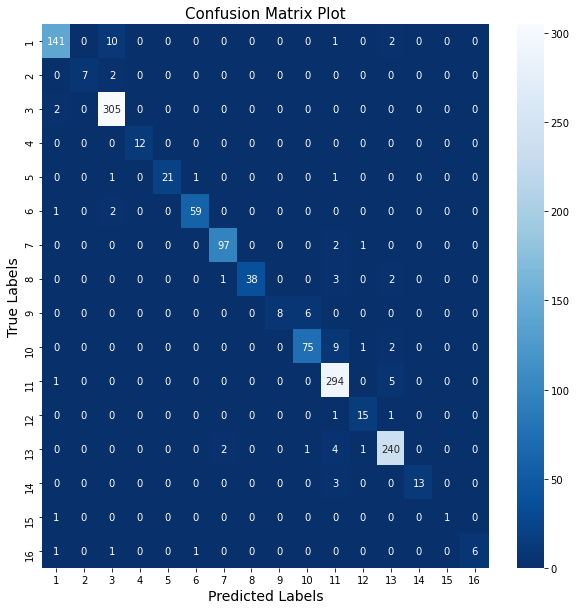

In [51]:
#Evaluating the model
functions.confusion(lp_predicted_test,test_true_labels,'Label Propagation')

#### 2.2.2 Tri-training

In [55]:
#Select the base estimators for tri-training
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=200)

classifiers = [
    RandomForestClassifier(),
    LogisticRegression(max_iter = 250000),
    ExtraTreesClassifier(),
    XGBClassifier(),
    GaussianNB(),
    SVC(),
    KNeighborsClassifier(),
]

result = list()
#Train on the base classifiers and to select top 3 classifiers using f1-score
for model in classifiers:    
    scores = cross_val_score(model, X_l, y_l, cv=kfold, scoring='f1_macro')
    score_description = " {} (+/- {})".format(scores.mean(), scores.std() * 2)
    result.append(scores.mean())
    print('{model:25} CV-5 f1 macro: {score}'.format(model=model.__class__.__name__,score=score_description))

RandomForestClassifier    CV-5 f1 macro:  0.9213136137698923 (+/- 0.05774836630933068)
LogisticRegression        CV-5 f1 macro:  0.853514095865408 (+/- 0.03201633439945818)
ExtraTreesClassifier      CV-5 f1 macro:  0.9164395731520208 (+/- 0.07165893006775405)
XGBClassifier             CV-5 f1 macro:  0.9034893627167989 (+/- 0.049245201262843534)
GaussianNB                CV-5 f1 macro:  0.8130873374406379 (+/- 0.051660201038724235)
SVC                       CV-5 f1 macro:  0.6512015770041947 (+/- 0.026753051278871093)
KNeighborsClassifier      CV-5 f1 macro:  0.802668928965128 (+/- 0.055774211587848545)


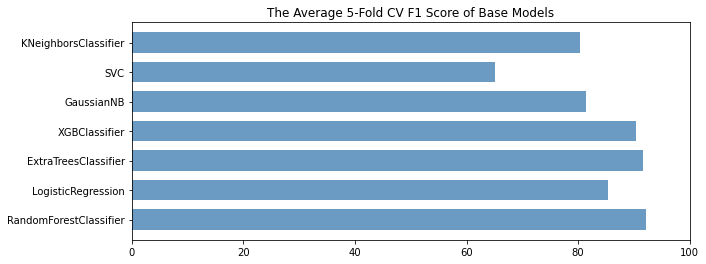

In [15]:
a = pd.DataFrame(results)
model = ['RandomForestClassifier','LogisticRegression','ExtraTreesClassifier','XGBClassifier','GaussianNB','SVC',
         'KNeighborsClassifier','MLPClassifier']
plt.figure(figsize=(10,4))

# Plot the score of each model
plt.barh(range(7), (a[0].values)*100, height=0.7, color='steelblue', alpha=0.8)
plt.yticks(range(7), model)
plt.xlim(0,100)
plt.title("The Average 5-Fold CV F1 Score of Base Models")
plt.savefig(r'CV Score of class Model(after semi).png',bbox_inches='tight')

Random forest, Extra trees and XGBoost are selected due to high f1 scores and are fune-tuned using grid search in below.

In [63]:
#Fine-tuning the selected model: extra trees
et = ExtraTreesClassifier()

grid_param={"n_estimators": [50, 100,150], 
           "max_features": ["auto","sqrt","log2"],
           "max_depth": [None,5,10], 
           "min_samples_split": [2,5,10],
           "min_samples_leaf": [1,2,5]}

gridsearch(et,grid_param)

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

In [93]:
#Fine-tuning the selected model: XGBoost
xgb = XGBClassifier()

n_estimators = [50, 100,300]
max_depth=[None,10, 50,100]

grid_param={"n_estimators": [50, 100,300], 
           "max_depth": [None,10, 50,100]}


gridsearch(xgb,grid_param)

{'max_depth': 50, 'n_estimators': 50}

In [70]:
#Fine-tuning the selected model: random forest
rf = RandomForestClassifier()

grid_param={"n_estimators": [50,100,150,200], 
           "max_features": ["auto","sqrt","log2"],
           "max_depth": [None,10,50,100], 
           "min_samples_split": [2,5,10,15],
           "min_samples_leaf": [1,5,10,15]}

gridsearch(rf,grid_param)

{'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 200}

Now we use the fine-tuned base classifiers to apply tri-training.

In [74]:
#Tri-training classifer
tt = TriTraining([ExtraTreesClassifier(max_depth= None,max_features='sqrt',min_samples_leaf= 1,min_samples_split= 10,n_estimators= 100,random_state=200),
                  RandomForestClassifier(max_depth= 50,max_features= 'sqrt',min_samples_leaf=1,min_samples_split= 10,n_estimators= 200),
                  XGBClassifier(max_depth= 50, n_estimators= 50,random_state=200)])
#Train the model and predict testing data
tt.fit(X_l.values,y_l.values,X_u.values)
tt_predicted_test = tt.predict(X_test.values)

Tri-training
              precision    recall  f1-score   support

           1     0.9733    0.9481    0.9605       154
           2     1.0000    0.7778    0.8750         9
           3     0.9804    0.9772    0.9788       307
           4     1.0000    1.0000    1.0000        12
           5     0.9583    0.9583    0.9583        24
           6     1.0000    0.9677    0.9836        62
           7     0.9706    0.9900    0.9802       100
           8     0.9773    0.9773    0.9773        44
           9     1.0000    0.7857    0.8800        14
          10     0.9560    1.0000    0.9775        87
          11     0.9833    0.9800    0.9816       300
          12     1.0000    1.0000    1.0000        17
          13     0.9425    0.9919    0.9666       248
          14     1.0000    0.8125    0.8966        16
          15     1.0000    1.0000    1.0000         2
          16     1.0000    0.6667    0.8000         9

    accuracy                         0.9722      1405
   macro avg 

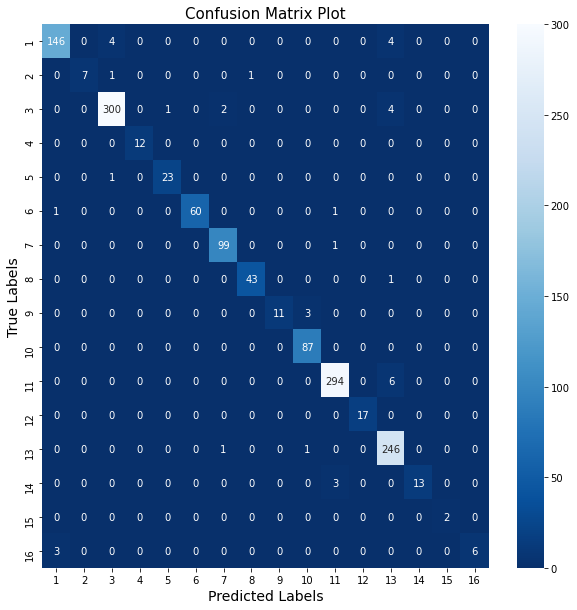

In [75]:
#Evaluate the model using testing results
functions.confusion(tt_predicted_test,test_true_labels,'Tri-training')

#### 2.2.3 Pseudo labeling

From Tri-training, we choose the best base estimator from the three fine-tuned estimators

In [71]:
#Check the best estimator
classifiers = [ExtraTreesClassifier(max_depth= None,max_features='sqrt',min_samples_leaf= 1,min_samples_split= 10,n_estimators= 100,random_state=200),
    RandomForestClassifier(max_depth= 50,max_features= 'sqrt',min_samples_leaf=1,min_samples_split= 10,n_estimators= 200),
    XGBClassifier(max_depth= 50, n_estimators= 50,random_state=200)
]

#Train on the base classifiers and to select top 3 classifiers using f1-score
for model in classifiers:    
    scores = cross_val_score(model, X_l, y_l, cv=kfold, scoring='f1_macro')
    score_description = " {} (+/- {})".format(scores.mean(), scores.std() * 2)
    print('{model:25} CV-5 f1 macro: {score}'.format(model=model.__class__.__name__,score=score_description))

ExtraTreesClassifier      CV-5 f1 macro:  0.9239606698421243 (+/- 0.054078051534990686)
RandomForestClassifier    CV-5 f1 macro:  0.9234722586994341 (+/- 0.053888443862123735)
XGBClassifier             CV-5 f1 macro:  0.9111851007794691 (+/- 0.04993590312640901)


Extra trees gave the highest F1_score, thus it is chosen as base estimator for pseudo labelling

In [76]:
#Set the model
pseudo = PseudoLabeler(ExtraTreesClassifier(max_depth= None,max_features='log2',min_samples_leaf= 1,min_samples_split= 10,n_estimators= 100,random_state=200),
    X_u,X_u.columns,'standard_transaction_type_id',sample_rate=0.3)

pseudo.seed = 42
#Fit dataset to the model
pseudo.fit(X_l, y_l)
#Predict testing labels
pse_predicted_test = pseudo.predict(X_test)

Pseudo Labelling
              precision    recall  f1-score   support

           1     0.9804    0.9740    0.9772       154
           2     1.0000    0.7778    0.8750         9
           3     0.9808    1.0000    0.9903       307
           4     1.0000    1.0000    1.0000        12
           5     1.0000    1.0000    1.0000        24
           6     1.0000    0.9677    0.9836        62
           7     1.0000    0.9900    0.9950       100
           8     0.9773    0.9773    0.9773        44
           9     1.0000    0.8571    0.9231        14
          10     0.9667    1.0000    0.9831        87
          11     0.9867    0.9900    0.9884       300
          12     1.0000    1.0000    1.0000        17
          13     0.9841    0.9960    0.9900       248
          14     1.0000    0.8125    0.8966        16
          15     1.0000    1.0000    1.0000         2
          16     1.0000    0.7778    0.8750         9

    accuracy                         0.9851      1405
   macro 

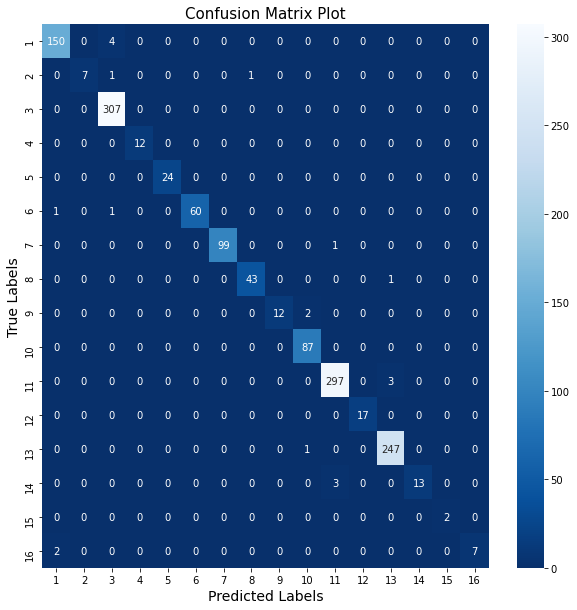

In [77]:
#Model evaluation using testing set
functions.confusion(pse_predicted_test,test_true_labels,'Pseudo Labelling')

#### 2.2.4 Majority Vote with Global rules

In [112]:
#Get a matrix with all prediction results of the three classifiers
prediction_test= np.vstack((lp_predicted_test,tt_predicted_test,pse_predicted_test)).T

#Majority vote and form a final column for results
vote_test = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=1, arr=prediction_test)
vote_df_test = pd.DataFrame(vote_test)
vote_df_test.index = test_indices

#pickcout the results that are not consistent, i.e. three classifiers produce three results
a = pd.DataFrame(prediction_test)
a.index = test_indices
#get their index
non_vote_index = a[(a.iloc[:,0]!=a.iloc[:,1])&(a.iloc[:,2]!=a.iloc[:,1])&(a.iloc[:,0]!=a.iloc[:,2])].index

#Get the global rule label of those inconsistent transactions 
global_non_vote = df_semi_unlabeled[df_semi_unlabeled.index.isin(non_vote_index)]
global_non_vote = global_non_vote['global']

#Change the weak labels to the same as global rule labels for those conflicting transactions only
for index in non_vote_index:
    vote_df_test.loc[index] = global_non_vote[index]

prediction_test_aft_vote = vote_df_test.to_numpy()

Weak Labels after Majority Vote
              precision    recall  f1-score   support

           1     0.9742    0.9805    0.9773       154
           2     1.0000    0.7778    0.8750         9
           3     0.9808    1.0000    0.9903       307
           4     1.0000    1.0000    1.0000        12
           5     1.0000    0.9583    0.9787        24
           6     1.0000    0.9677    0.9836        62
           7     1.0000    0.9900    0.9950       100
           8     0.9773    0.9773    0.9773        44
           9     1.0000    0.8571    0.9231        14
          10     0.9667    1.0000    0.9831        87
          11     0.9866    0.9800    0.9833       300
          12     1.0000    1.0000    1.0000        17
          13     0.9724    0.9960    0.9841       248
          14     1.0000    0.8125    0.8966        16
          15     1.0000    1.0000    1.0000         2
          16     1.0000    0.6667    0.8000         9

    accuracy                         0.9822     

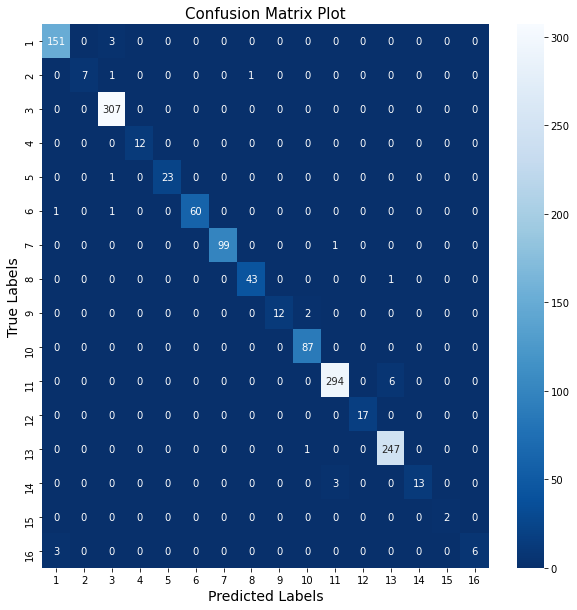

In [114]:
#Get evluation matrix
functions.confusion(prediction_test_aft_vote,test_true_labels,'Weak Labels after Majority Vote')

### 2.3 Predicting transactions for those without gold labels

In [115]:
#Predict labels of those local rule unlabelled transactions
lp_predict = lp_model.predict(X_u.values)
tt_predict = tt.predict(X_u.values)
pse_predict = pseudo.predict(X_u)
#Combine those predictions
predictions= np.vstack((lp_predict, tt_predict,pse_predict)).T

#Majority Vote
vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=1, arr=predictions)
vote_df = pd.DataFrame(vote)
vote_df.index = semi_y_unlabeled.index

#Get the index and transactions of those inconsistent predictions
a = pd.DataFrame(predictions)
a.index = semi_y_unlabeled.index
non_vote_index = a[(a.iloc[:,0]!=a.iloc[:,1])&(a.iloc[:,2]!=a.iloc[:,1])&(a.iloc[:,0]!=a.iloc[:,2])].index

#Find global rule of those inconsistents 
global_non_vote = df_semi_unlabeled[df_semi_unlabeled.index.isin(non_vote_index)]
global_non_vote = global_non_vote['global']

#Change the predicted labels to global-labelled classes for those inconsistent
for index in non_vote_index:
    vote_df.loc[index] = global_non_vote[index]

### 2.4 Form the weak labelled dataframe

In [118]:
#Create a weak label variable
df['weak_label'] = df['standard_transaction_type_id']
#Change the labels to weak labels in the final datafrmae
for index in semi_y_unlabeled.index:
    df.loc[index,'weak_label'] = vote_df.loc[index].values[0]

In [119]:
#Check the distribution of weak labels
df['weak_label'].value_counts()

-1     106727
 13      2370
 3       1366
 11      1096
 1        915
 7        816
 10       330
 6        219
 8        211
 5         68
 12        62
 14        50
 9         42
 2         41
 4         30
 16        18
 15         8
Name: weak_label, dtype: int64

In [120]:
#Replace weak labels of -1 by 0 for future analysis as -1 is only used for semi-supervised classification stage
df['weak_label'].replace(-1, 0,inplace=True)

In [51]:
df.to_csv(r'df_post_weak_label.csv',index = False)

In [132]:
df.to_csv(r'df_post_weak_label_updated.csv',index = False)

In [133]:
vote_df.to_csv(r'df_unlabeled_data_labels.csv',index = False)